# Aula 1

## Carregando os dados

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['font.size'] = 22

/home/emmanuel/.pyenv/versions/3.6.8/envs/cranium/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/emmanuel/.pyenv/versions/3.6.8/envs/cranium/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/emmanuel/.pyenv/versions/3.6.8/envs/cranium/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/emmanuel/.pyenv/versions/3.6.8/envs/cranium/lib/p

In [2]:
def carregar_dados():
    passageiros = pd.read_csv('Passageiros.csv')
    print(passageiros.head())
    return passageiros

passageiros = carregar_dados()

         tempo  passageiros
0  1949.000000          112
1  1949.083333          118
2  1949.166667          132
3  1949.250000          129
4  1949.333333          121


In [3]:
def plotar_dados_completos():
    sns.lineplot(x='tempo',y='passageiros', data=passageiros,label='dado_completo') 

## Escalando os dados

In [4]:
def escalar_dados():
    sc = StandardScaler()
    sc.fit(passageiros)
    dado_escalado = sc.transform(passageiros)
    x=dado_escalado[:,0] #Features - Características - Tempo
    y=dado_escalado[:,1] #Alvo - Número de passageiros
    return x, y

x_escalado, y_escalado = escalar_dados()

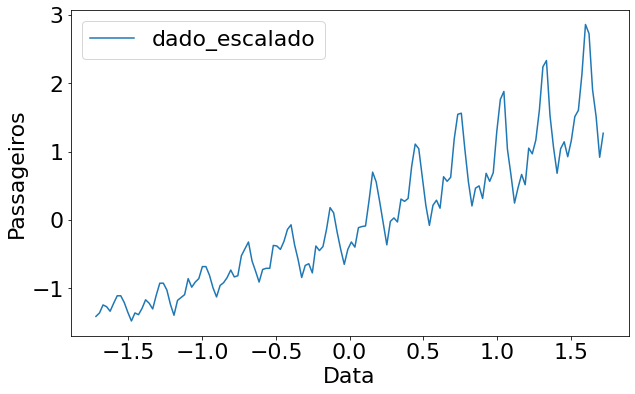

In [5]:
def plotar_eixos(x,y,label):
    sns.lineplot(x=x,y=y,label=label) 
    plt.ylabel('Passageiros')
    plt.xlabel('Data')

    
plotar_eixos(x_escalado, y_escalado, 'dado_escalado')

## Dividindo em treino e teste

In [6]:
def dividir_treino_teste(tamanho_percentual_treino):
    tamanho_treino = int(len(passageiros)*tamanho_percentual_treino) 
    tamanho_teste = int(len(passageiros)-tamanho_treino)
    xtreino = x_escalado[0:tamanho_treino]
    ytreino = y_escalado[0:tamanho_treino]
    xteste = x_escalado[tamanho_treino:len(passageiros)]
    yteste = y_escalado[tamanho_treino:len(passageiros)]
    return xtreino, ytreino, xteste, yteste
    
x_treino, y_treino, x_teste, y_teste = dividir_treino_teste(0.8)

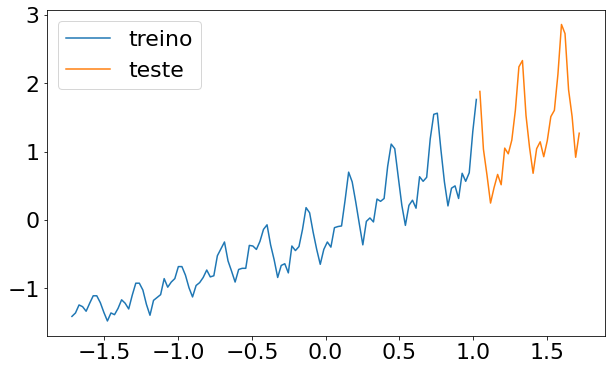

In [9]:
def plotar_eixos(x,y, label):
    sns.lineplot(x=x,y=y,label=label) 

plotar_eixos(x_treino, y_treino, 'treino')    
plotar_eixos(x_teste, y_teste, 'teste')

# Aula 2

## Regressão Linear

In [37]:
def definir_modelo(hyperparams=[], input_dim=1, loss='mean_squared_error', optimizer='adam'):
    
    modelo = Sequential()

    if (hyperparams[0]['input_dim'] is not None):
        input_dim = hyperparams[0]['input_dim']

    for i in range(0, len(hyperparams)):

        modelo.add(Dense(hyperparams[i]['dimensao_saida'],
                         input_dim=input_dim,
                         activation=hyperparams[i]['activation'],
                         kernel_initializer=hyperparams[i]['kernel_initializer'],
                         use_bias=hyperparams[i]['use_bias']))

    modelo.compile(loss=loss,
                   metrics=['accuracy'],
                   optimizer=optimizer)

    modelo.summary()

    return modelo

In [38]:
def plotar_resultados(x, y):
    dados = {'tempo':x, 'passageiros': y[:,0]}
    resultados = pd.DataFrame(data=dados)
    resultados_inversos = sc.inverse_transform(resultados)
    x, y = resultados_inversos[:,0], resultados_inversos[:,1]
    plotar_eixos(x, y, 'predições')

In [39]:
def testar_modelo(hyperparams, epocas_treino=5):
    
    dados = passageiros
        
    modelo = definir_modelo(hyperparams)
    modelo.fit(x_treino, y_treino, epochs=epocas_treino)
    y_predict = modelo.predict(x_treino)
    y_predict_teste = modelo.predict(x_teste)
    
    plotar_dados_completos()
    plotar_resultados(x_treino, y_predict)
    plotar_resultados(x_teste, y_predict_teste)

In [40]:
hyperparams_1=[{
    
    'dimensao_saida':1,
    'activation':'linear',
    'kernel_initializer':'Ones',
    'use_bias':True
}]

#testar_modelo(hyperparams=hyperparams_1)

## Regressão não-linear

In [41]:
hyperparams_4 = [{
    
    'dimensao_saida':8,
   'activation':'sigmoid',
    'kernel_initializer':'random_uniform',
    'use_bias':False
    
},


{
    'dimensao_saida':8,
   'activation':'sigmoid',
    'kernel_initializer':'random_uniform',
    'use_bias':False
    
},
    
    {
    'dimensao_saida':1,
    'activation':'linear',
    'kernel_initializer':'random_uniform',
    'use_bias':False
    
}

]

#testar_modelo(hyperparams_4, epocas_treino=500)

# Aula 3

## Alterando a forma como passamos os dados

Agora x e y vão valores diferentes. X vai conter o número de passageiros em um tempo anterior e y vai conter o número de passageiros em t+1, por exemplo. 

In [42]:
def separa_dados(dados_seriados, n_passos):
    
  """Entrada: vetor: número de passageiros
               n_passos: número de passos no regressor
     Saída:
              X_novo: Array 2D 
              y_novo: Array 1D - Nosso alvo
  """
  vetor = pd.DataFrame(dados_seriados)[0]
  X_novo, y_novo = [], []
  for i in range(n_passos,vetor.shape[0]):
    X_novo.append(list(vetor.loc[i-n_passos:i-1]))
    y_novo.append(vetor.loc[i])
  X_novo, y_novo = np.array(X_novo), np.array(y_novo) 
  return X_novo, y_novo

In [44]:
n_passos = 1
xtreino_novo, ytreino_novo = separa_dados(y_treino, n_passos)
xteste_novo, yteste_novo = separa_dados(y_teste, n_passos)

## Agora vamos separar o teste

## Voltando para as redes neurais

In [45]:
hyperparams_5 = [{
    
    'dimensao_saida':8,
   'activation':'linear',
    'kernel_initializer':'ones',
    'use_bias':False,
    'input_dim':n_passos
    
},


{
    'dimensao_saida':64,
   'activation':'sigmoid',
    'kernel_initializer':'random_uniform',
    'use_bias':False,
    
},
    
    {
    'dimensao_saida':1,
    'activation':'linear',
    'kernel_initializer':'random_uniform',
    'use_bias':False,
    
}



]

regressor3 = definir_modelo(hyperparams_5)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8)                 8         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 64        
Total params: 584
Trainable params: 584
Non-trainable params: 0
_________________________________________________________________


In [46]:
regressor3.fit(xtreino_novo,ytreino_novo,epochs =100)

Epoch 1/100
114/114 [==============================] - 0s 401us/sample - loss: 0.5804 - acc: 0.0000e+00
Epoch 2/100
114/114 [==============================] - 0s 54us/sample - loss: 0.5482 - acc: 0.0000e+00
Epoch 3/100
114/114 [==============================] - 0s 52us/sample - loss: 0.5376 - acc: 0.0000e+00
Epoch 4/100
114/114 [==============================] - 0s 62us/sample - loss: 0.5207 - acc: 0.0000e+00
Epoch 5/100
114/114 [==============================] - 0s 59us/sample - loss: 0.5018 - acc: 0.0000e+00
Epoch 6/100
114/114 [==============================] - 0s 78us/sample - loss: 0.4851 - acc: 0.0000e+00
Epoch 7/100
114/114 [==============================] - 0s 96us/sample - loss: 0.4674 - acc: 0.0000e+00
Epoch 8/100
114/114 [==============================] - 0s 87us/sample - loss: 0.4511 - acc: 0.0000e+00
Epoch 9/100
114/114 [==============================] - 0s 60us/sample - loss: 0.4310 - acc: 0.0000e+00
Epoch 10/100
114/114 [==============================] - 0s 85us/sample -

114/114 [==============================] - 0s 58us/sample - loss: 0.0499 - acc: 0.0000e+00
Epoch 80/100
114/114 [==============================] - 0s 52us/sample - loss: 0.0500 - acc: 0.0000e+00
Epoch 81/100
114/114 [==============================] - 0s 50us/sample - loss: 0.0501 - acc: 0.0000e+00
Epoch 82/100
114/114 [==============================] - 0s 99us/sample - loss: 0.0501 - acc: 0.0000e+00
Epoch 83/100
114/114 [==============================] - 0s 83us/sample - loss: 0.0500 - acc: 0.0000e+00
Epoch 84/100
114/114 [==============================] - 0s 80us/sample - loss: 0.0502 - acc: 0.0000e+00
Epoch 85/100
114/114 [==============================] - 0s 68us/sample - loss: 0.0501 - acc: 0.0000e+00
Epoch 86/100
114/114 [==============================] - 0s 59us/sample - loss: 0.0501 - acc: 0.0000e+00
Epoch 87/100
114/114 [==============================] - 0s 67us/sample - loss: 0.0500 - acc: 0.0000e+00
Epoch 88/100
114/114 [==============================] - 0s 61us/sample - loss

In [47]:
y_predict_novo = regressor3.predict(xtreino_novo)

In [48]:
def plotar_resultado_treino_dados_alterados(y, dados, label):
    sns.lineplot(x='tempo',y=y,data=dados,label=label)

In [49]:
y_predict_teste_novo = regressor3.predict(xteste_novo)

In [50]:
resultado = pd.DataFrame(y_predict_teste_novo)[0]

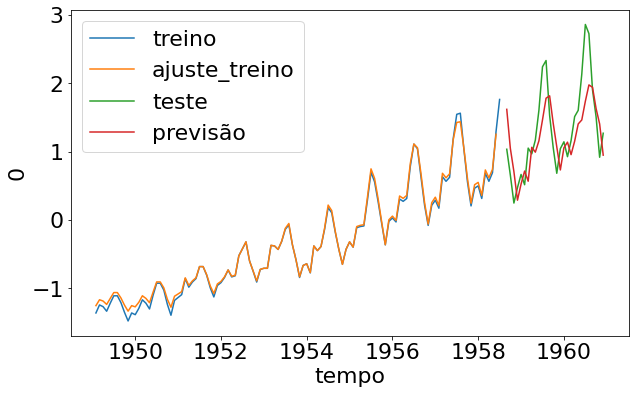

In [51]:
plotar_resultado_treino_dados_alterados(ytreino_novo, passageiros[1:115], 'treino')
plotar_resultado_treino_dados_alterados(pd.DataFrame(y_predict_novo)[0], passageiros[1:115], 'ajuste_treino')
plotar_resultado_treino_dados_alterados(yteste_novo, passageiros[116:144], 'teste')
plotar_resultado_treino_dados_alterados(resultado.values, passageiros[116:144], 'previsão')

## Janelas

In [52]:
n_passos = 4
xtreino_novo, ytreino_novo = separa_dados(y_treino, n_passos)
xteste_novo, yteste_novo = separa_dados(y_teste, n_passos)

In [54]:
hyperparams_6 = [{
    
    
    'dimensao_saida':8,
   'activation':'linear',
    'kernel_initializer':'random_uniform',
    'use_bias':False,
    'input_dim':n_passos
    
},


{
    'dimensao_saida':64,
   'activation':'sigmoid',
    'kernel_initializer':'random_uniform',
    'use_bias':False,
    
},
    
    {
    'dimensao_saida':1,
    'activation':'linear',
    'kernel_initializer':'random_uniform',
    'use_bias':False,
    
}



]

regressor4 = definir_modelo(hyperparams_6)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 8)                 32        
_________________________________________________________________
dense_13 (Dense)             (None, 64)                512       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 64        
Total params: 608
Trainable params: 608
Non-trainable params: 0
_________________________________________________________________


In [55]:
regressor4.fit(xtreino_novo,ytreino_novo,epochs =300)

Epoch 1/300
111/111 [==============================] - 0s 430us/sample - loss: 0.5874 - acc: 0.0000e+00
Epoch 2/300
111/111 [==============================] - 0s 61us/sample - loss: 0.5627 - acc: 0.0000e+00
Epoch 3/300
111/111 [==============================] - 0s 76us/sample - loss: 0.5635 - acc: 0.0000e+00
Epoch 4/300
111/111 [==============================] - 0s 56us/sample - loss: 0.5657 - acc: 0.0000e+00
Epoch 5/300
111/111 [==============================] - 0s 72us/sample - loss: 0.5649 - acc: 0.0000e+00
Epoch 6/300
111/111 [==============================] - 0s 63us/sample - loss: 0.5601 - acc: 0.0000e+00
Epoch 7/300
111/111 [==============================] - 0s 68us/sample - loss: 0.5562 - acc: 0.0000e+00
Epoch 8/300
111/111 [==============================] - 0s 53us/sample - loss: 0.5502 - acc: 0.0000e+00
Epoch 9/300
111/111 [==============================] - 0s 60us/sample - loss: 0.5459 - acc: 0.0000e+00
Epoch 10/300
111/111 [==============================] - 0s 59us/sample -

111/111 [==============================] - 0s 61us/sample - loss: 0.0871 - acc: 0.0000e+00
Epoch 80/300
111/111 [==============================] - 0s 65us/sample - loss: 0.0866 - acc: 0.0000e+00
Epoch 81/300
111/111 [==============================] - 0s 59us/sample - loss: 0.0862 - acc: 0.0000e+00
Epoch 82/300
111/111 [==============================] - 0s 79us/sample - loss: 0.0859 - acc: 0.0000e+00
Epoch 83/300
111/111 [==============================] - 0s 119us/sample - loss: 0.0861 - acc: 0.0000e+00
Epoch 84/300
111/111 [==============================] - 0s 54us/sample - loss: 0.0847 - acc: 0.0000e+00
Epoch 85/300
111/111 [==============================] - 0s 98us/sample - loss: 0.0842 - acc: 0.0000e+00
Epoch 86/300
111/111 [==============================] - ETA: 0s - loss: 0.0893 - acc: 0.0000e+0 - 0s 50us/sample - loss: 0.0839 - acc: 0.0000e+00
Epoch 87/300
111/111 [==============================] - 0s 54us/sample - loss: 0.0835 - acc: 0.0000e+00
Epoch 88/300
111/111 [============

111/111 [==============================] - 0s 59us/sample - loss: 0.0582 - acc: 0.0000e+00
Epoch 157/300
111/111 [==============================] - 0s 54us/sample - loss: 0.0578 - acc: 0.0000e+00
Epoch 158/300
111/111 [==============================] - 0s 68us/sample - loss: 0.0574 - acc: 0.0000e+00
Epoch 159/300
111/111 [==============================] - 0s 61us/sample - loss: 0.0574 - acc: 0.0000e+00
Epoch 160/300
111/111 [==============================] - 0s 93us/sample - loss: 0.0575 - acc: 0.0000e+00
Epoch 161/300
111/111 [==============================] - 0s 66us/sample - loss: 0.0570 - acc: 0.0000e+00
Epoch 162/300
111/111 [==============================] - 0s 53us/sample - loss: 0.0571 - acc: 0.0000e+00
Epoch 163/300
111/111 [==============================] - 0s 64us/sample - loss: 0.0566 - acc: 0.0000e+00
Epoch 164/300
111/111 [==============================] - 0s 53us/sample - loss: 0.0567 - acc: 0.0000e+00
Epoch 165/300
111/111 [==============================] - 0s 54us/samp

111/111 [==============================] - 0s 57us/sample - loss: 0.0501 - acc: 0.0000e+00
Epoch 234/300
111/111 [==============================] - 0s 56us/sample - loss: 0.0502 - acc: 0.0000e+00
Epoch 235/300
111/111 [==============================] - 0s 57us/sample - loss: 0.0502 - acc: 0.0000e+00
Epoch 236/300
111/111 [==============================] - 0s 53us/sample - loss: 0.0500 - acc: 0.0000e+00
Epoch 237/300
111/111 [==============================] - 0s 65us/sample - loss: 0.0499 - acc: 0.0000e+00
Epoch 238/300
111/111 [==============================] - 0s 72us/sample - loss: 0.0496 - acc: 0.0000e+00
Epoch 239/300
111/111 [==============================] - 0s 52us/sample - loss: 0.0498 - acc: 0.0000e+00
Epoch 240/300
111/111 [==============================] - 0s 60us/sample - loss: 0.0496 - acc: 0.0000e+00
Epoch 241/300
111/111 [==============================] - 0s 50us/sample - loss: 0.0496 - acc: 0.0000e+00
Epoch 242/300
111/111 [==============================] - 0s 86us/samp

In [56]:
y_predict_teste_novo = regressor4.predict(xteste_novo)

In [57]:
resultado = pd.DataFrame(y_predict_teste_novo)[0]

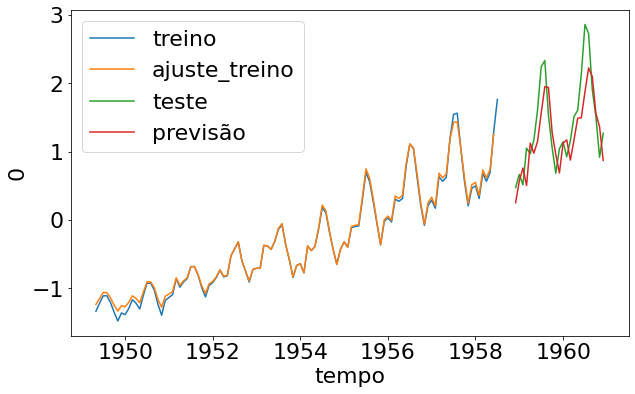

In [58]:
plotar_resultado_treino_dados_alterados(ytreino_novo, passageiros[4:115], 'treino')
plotar_resultado_treino_dados_alterados(pd.DataFrame(y_predict_novo)[0], passageiros[4:115], 'ajuste_treino')
plotar_resultado_treino_dados_alterados(yteste_novo, passageiros[119:144], 'teste')
plotar_resultado_treino_dados_alterados(resultado.values, passageiros[119:144], 'previsão')